In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Подготовка данных часть 1

In [2]:
#Orders
df_orders = pd.read_csv('orders.csv')
df_orders['order_month'] = df_orders['order_date'].apply(lambda x: x[0:7])
df_orders['order_year'] = df_orders['order_date'].apply(lambda x: x[0:4])

#Customers
df_customers = pd.read_csv('customers.csv')
cols = ['customer_id']
cols.extend(df_customers.columns[1:])
df_customers.columns = cols

In [3]:
#Merge data with orders and customers
df_merged = pd.merge(df_orders, df_customers, how='inner', on='customer_id')

#Calculate the year of the first order for each customer
df_first = df_merged.groupby('customer_id').agg({'order_year': 'min'}).reset_index()
df_first.columns = ['customer_id', 'first_order']

df_full = pd.merge(df_merged, df_first, 'inner', on='customer_id')
df_full.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city,first_order
3685,160514,2017-11-12,Standard,DB-13120,10.560,2017-11,2017,David Bremer,Corporate,California,Santa Clara,2015
3021,148614,2014-01-20,Standard,MV-17485,38.660,2014-01,2014,Mark Van Huff,Consumer,Virginia,Arlington,2014
735,104129,2015-02-27,Standard,ES-14080,599.900,2015-02,2015,Erin Smith,Corporate,Florida,Melbourne,2014
3527,105284,2016-11-24,Standard,MG-17650,4.416,2016-11,2016,Matthew Grinstein,Home Office,Pennsylvania,Philadelphia,2014
1610,121167,2014-11-28,Second,MO-17500,17.248,2014-11,2014,Mary O'Rourke,Consumer,New York,New York City,2014


In [4]:
#Считаем по когортам уникальных пользователей каждый год
df_users1 = df_full.groupby(['first_order', 'order_year', 'customer_id'])['order_date']\
    .min().reset_index()
df_users1.columns = ['first_order', 'order_year', 'customer_id', 'min_order']

#Считаем по когортам уникальных пользователей каждый год с разделением по признаку segment
df_users2 = df_full.groupby(['first_order', 'order_year', 'customer_id', 'segment'])['order_date']\
    .min().reset_index()
df_users2.columns = ['first_order', 'order_year', 'customer_id', 'segment', 'min_date_segment']

#Считаем по когортам уникальных пользователей каждый год с разделением по признаку ship_mode
df_users3 = df_full.groupby(['first_order', 'order_year', 'customer_id', 'ship_mode'])['order_date']\
    .min().reset_index()
df_users3.columns = ['first_order', 'order_year', 'customer_id', 'ship_mode', 'min_date_ship_mode']

# График retention пользователей

In [5]:
def create_plot1(df, title, ylabel):
    plt.figure(figsize=(8, 6))
    plt.margins(x=0, y=0) 
    
    plt.plot(np.arange(0, 4), df[df.first_order == '2014'].customer_id / 
             np.array(df[(df.first_order == '2014') & (df.order_year == '2014')].customer_id))
    plt.fill_between(np.arange(0, 4), 
                     df[df.first_order == '2014'].customer_id / 
                     np.array(df[(df.first_order == '2014') & (df.order_year == '2014')].customer_id),
                     alpha=0.2, label='2014')
    
    plt.plot(np.arange(0, 3), df[df.first_order == '2015'].customer_id / 
             np.array(df[(df.first_order == '2015') & (df.order_year == '2015')].customer_id))
    plt.fill_between(np.arange(0, 3), 
                     df[df.first_order == '2015'].customer_id / 
                     np.array(df[(df.first_order == '2015') & (df.order_year == '2015')].customer_id),
                     alpha=0.4, label='2015')
    
    plt.plot(np.arange(0, 2), df[df.first_order == '2016'].customer_id /
             np.array(df[(df.first_order == '2016') & (df.order_year == '2016')].customer_id))
    plt.fill_between(np.arange(0, 2), 
                     df[df.first_order == '2016'].customer_id /
                     np.array(df[(df.first_order == '2016') & (df.order_year == '2016')].customer_id),
                     alpha=0.6, label='2016')

    plt.title(title, fontsize=15)
    plt.xlabel('Year since first order', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(loc='upper right', fontsize=14)
    plt.show()

## Глобальный retention 

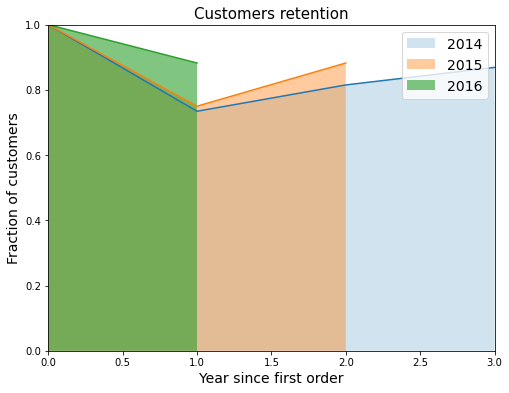

In [6]:
create_plot1(df_users1.groupby(['first_order', 'order_year'])\
             .agg({'customer_id': 'count'}).reset_index(), 
             'Customers retention', 'Fraction of customers')

## Retention в зависимости от сегмента покупателя

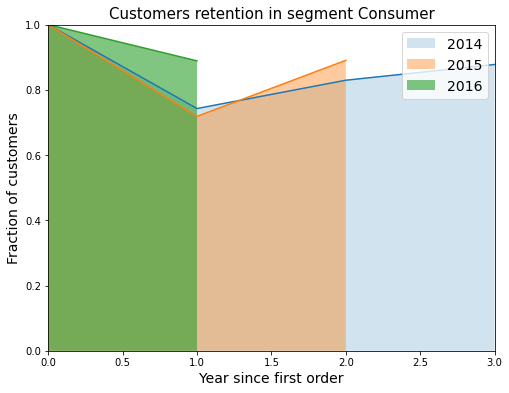

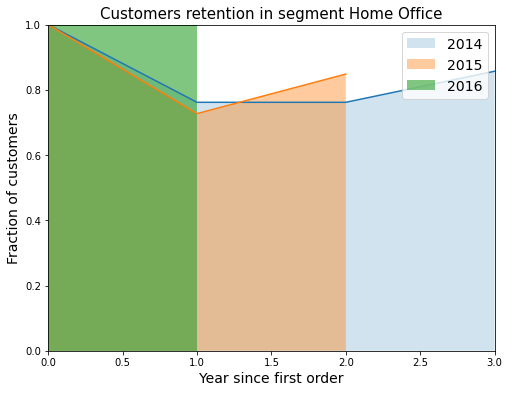

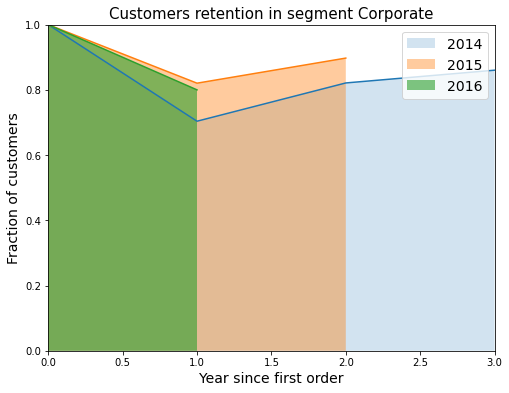

In [7]:
for segment in df_users2.segment.unique():
    create_plot1(df_users2[df_users2.segment == segment].groupby(['first_order', 'order_year'])\
                 .agg({'customer_id': 'count'}).reset_index(), 
                 f'Customers retention in segment {segment}', 'Fraction of customers')

## Retention в зависимости от типа доставки

Графики показывают отношение доставок того или иного типа для каждой когорты в течении периода 2014-2017 по сравнению с количеством соответстующих доставок в первый год покупок.

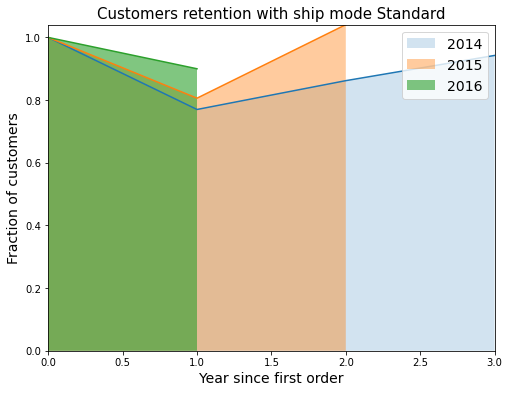

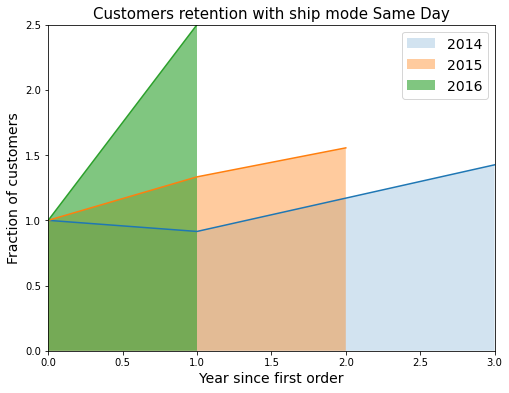

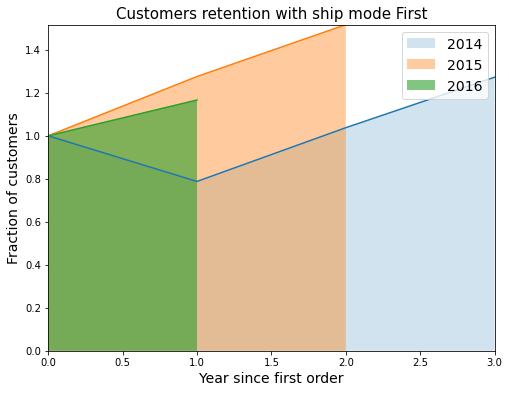

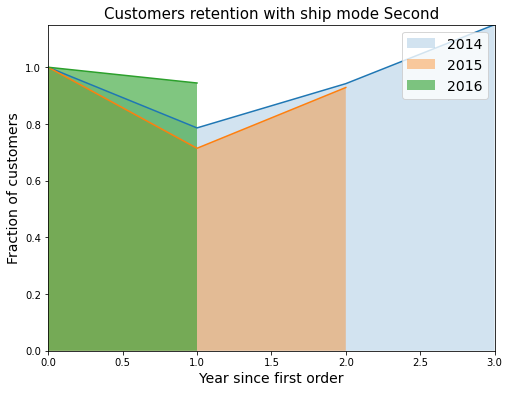

In [8]:
for ship_mode in df_users3.ship_mode.unique():
    create_plot1(df_users3[df_users3.ship_mode == ship_mode].groupby(['first_order', 'order_year'])\
                 .agg({'customer_id': 'count'}).reset_index(), 
                 f'Customers retention with ship mode {ship_mode}', 'Fraction of customers')

## Вывод

График глобального retention не позволяет подтвердить гипотезу руководителя продукта. Если посмотреть на изменение retention для каждой из когорт 2015/2016 (год совершения первой покупки), то тенденции у них в период 2016-2017 те же, что и у когорт до них в период 2015-2016. То есть изменение retention объясняется скорее количеством лет после совершения первой покупки. Что же до когорты 2014, то в период 2016-2017 retention вырос (причём, судя по другим графикам, равномерно в зависимости от сегмента пользователя и типа доставки).

Из интересного: в период 2016-2017 у всех когорт наблюдался рост retention в разделах segment = 'Home Office'/'Consumer', а также в ship_mode = 'Standard'/'Same day'/'Second'. 

# Подготовка данных часть 2

In [9]:
df_users = df_full.groupby(['customer_id', 'first_order', 'order_year', 'ship_mode', 'segment'])\
    .agg({'sales': 'sum', 'id': 'count'}).reset_index()

df_users.head()

,customer_id,first_order,order_year,ship_mode,segment,sales,id
0,AA-10315,2014,2014,Standard,Consumer,756.048,2
1,AA-10315,2014,2015,First,Consumer,26.960,1
2,AA-10315,2014,2016,Standard,Consumer,4406.072,1
3,AA-10315,2014,2017,Standard,Consumer,374.480,1
4,AA-10375,2014,2014,Standard,Consumer,50.792,2


In [10]:
def get_crosstab(df, value_col):
    df_crosstab = pd.crosstab(df['customer_id'], df['order_year'], 
                              values=df[value_col], aggfunc=sum).reset_index()
    df_crosstab = pd.merge(df_first, df_crosstab, 'inner', on='customer_id')
    del df_crosstab['customer_id']
    return df_crosstab

In [11]:
def calculate_retention(df):
    df_triangle = df.groupby(df.first_order).sum().reset_index()
    df_triangle['base'] = np.diag(df_triangle.iloc[:, 1:])
    df_retention = pd.DataFrame(df_triangle[['first_order', 'base']])
    df_retention.columns = ['Cohort', 'Base']
    
    for col in df_triangle.columns[1:-1]:
        df_retention[col] = round(df_triangle[col] / df_triangle['base'], 3)
        
    for i in range(2, len(df_retention.columns)):
        df_retention.iloc[i-1:, i] = None
        
    return df_retention

In [12]:
sales_retention = calculate_retention(get_crosstab(df_users, 'sales'))
sales_retention.head()

,Cohort,Base,2014,2015,2016,2017
0,2014,484247.4981,1.0,0.754,0.939,1.101
1,2015,105388.4962,NaN,1.000,0.944,1.250
2,2016,54803.6200,NaN,NaN,1.000,1.111
3,2017,7511.8050,NaN,NaN,NaN,1.000


In [13]:
transaction_retention = calculate_retention(get_crosstab(df_users, 'id'))
transaction_retention.head()

,Cohort,Base,2014,2015,2016,2017
0,2014,969.0,1.0,0.833,1.028,1.288
1,2015,231.0,NaN,1.000,0.931,1.268
2,2016,104.0,NaN,NaN,1.000,1.221
3,2017,19.0,NaN,NaN,NaN,1.000


# Графики retention для продаж и транзакций

In [14]:
def create_plot2(df, title, ylabel):
    plt.figure(figsize=(8, 6))
    plt.margins(x=0, y=0) 
    
    plt.plot(np.arange(0, 4), np.array(df.iloc[0, 2:], dtype=float))
    plt.fill_between(np.arange(0, 4), 
                     np.array(df.iloc[0, 2:], dtype=float),
                     alpha=0.2, label='2014')
    
    plt.plot(np.arange(0, 4), np.roll(np.array(df.iloc[1, 2:], dtype=float), -1))
    plt.fill_between(np.arange(0, 4), 
                     np.roll(np.array(df.iloc[1, 2:], dtype=float), -1),
                     alpha=0.4, label='2015')
    
    plt.plot(np.arange(0, 4), np.roll(np.array(df.iloc[2, 2:], dtype=float), -2))
    plt.fill_between(np.arange(0, 4), 
                     np.roll(np.array(df.iloc[2, 2:], dtype=float), -2),
                     alpha=0.6, label='2016')

    plt.title(title, fontsize=15)
    plt.xlabel('Year since first order', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(loc='upper right', fontsize=14)
    plt.show()

## Изменение в объёме продаж по когортам  

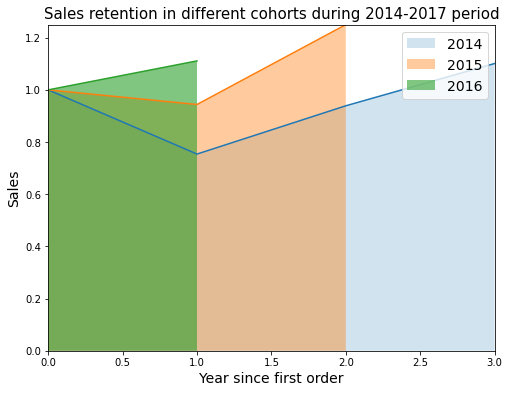

In [15]:
create_plot2(sales_retention, 'Sales retention in different cohorts during 2014-2017 period',
             'Sales')

## Изменение в количестве транзакций по когортам 

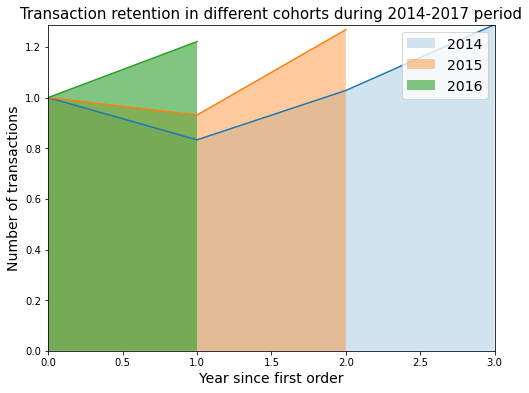

In [16]:
create_plot2(transaction_retention, 'Transaction retention in different cohorts during 2014-2017 period',
             'Number of transactions')

## Изменение количества транзакций в зависимости от типа доставки

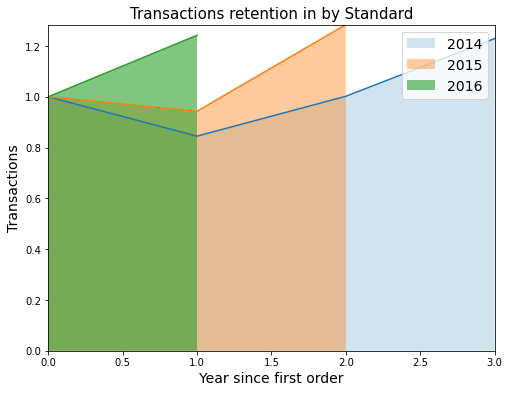

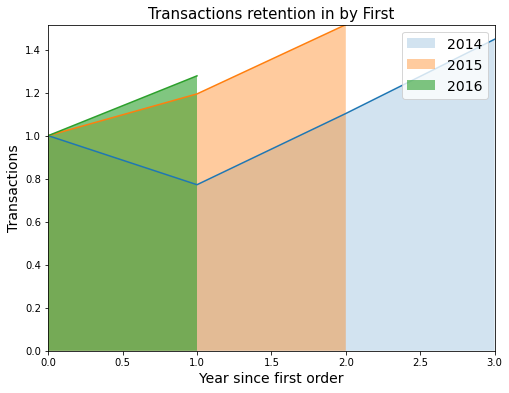

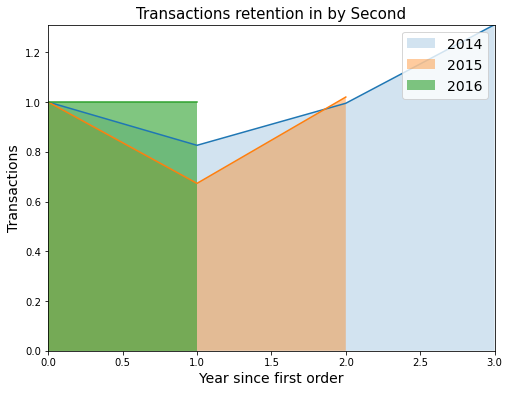

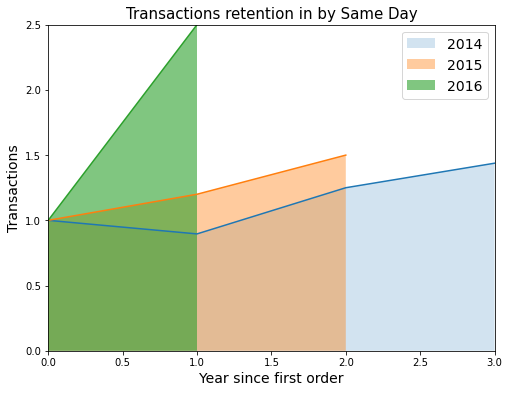

In [17]:
for ship_mode in df_users.ship_mode.unique():
    df_new = calculate_retention(get_crosstab(df_users[df_users.ship_mode == ship_mode], 'id'))
    create_plot2(df_new, f'Transactions retention in by {ship_mode}', 'Transactions')

## Изменение количества транзакций в зависимости от сегмента покупателя

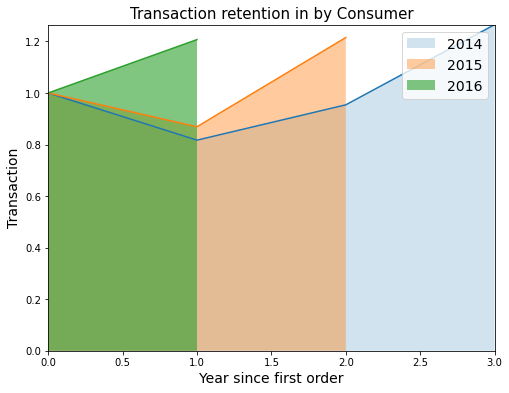

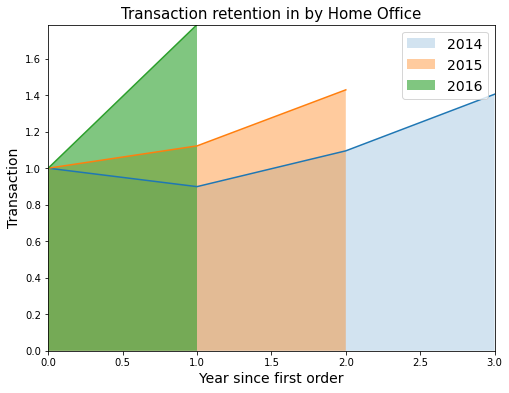

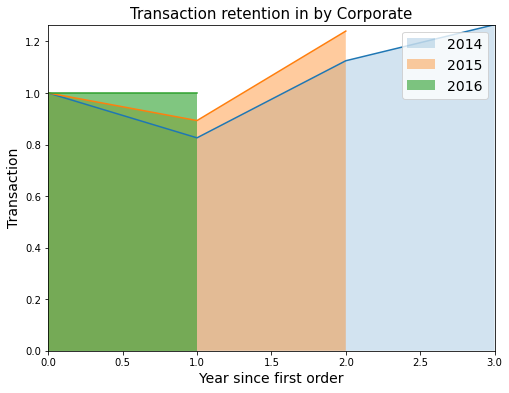

In [18]:
for segment in df_users.segment.unique():
    df_new = calculate_retention(get_crosstab(df_users[df_users.segment == segment], 'id'))
    create_plot2(df_new, f'Transaction retention in by {segment}', 'Transaction')

## Вывод

На графиках выше приведён retention для продаж и транзакций. Глядя на эти графики руководитель может самостоятельно оценить, насколько объём продаж/транзакций соответсвует каждой когорте в данный промежуток времени в зависимости от того, сколько лет прошло после первой покупки. Также на них он может заметить тенденции когорт, отличные от тенденций когорт до них в соответствующий промежуток после первой покупки - так можно отслеживать влияние изменений в продукте.